In [33]:
# Code referenced from:
# https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial

import csv
import os
import re
import string
import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

## run once
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [22]:
df = pd.read_csv('../airflow/data/staging/result_big_table/result.csv',
                 sep='\\t',
                 header=None,
                 engine='python',
                 names=['job_id', 'job_title', 'company_name', 
                        'job_description', 'location', 'official_post_date',
                        'min_official_salary', 'max_official_salary', 'career_level',
                        'qualification', 'job_type', 'job_functions', 'industry',
                        'min_salary', 'max_salary']
                )

df['job_description'] = df['job_description'].astype(str)
df = df.replace(r'\\n+|\\t+\\r+',' ', regex=True)
df = df.dropna(subset=['job_description'])
df['mid_salary'] = ((df['min_salary'] + df['max_salary']) / 2).astype(int)

df

job_id                                          job_title  \
0      100003009505754  Distributed Data Analysis Framework Technical ...   
1      100003009506099         System Manager - (System & Infrastructure)   
2      100003009505884  Engineer Project Associate - Small Appliances ...   
3      100003009505952          Facility Engineer (  Facility Management)   
4      110000000155879                       Research Assistant Professor   
...                ...                                                ...   
35642  100003009502482                        Senior IT Portfolio Manager   
35643  100003009504117    People Insights Business Partner - (2200016745)   
35644  100003009504618                                 IT Support Manager   
35645  100003009505110                      Business Analyst (5-day work)   
35646  100003009505124                      Solution Analyst (職位編號：SA-HO)   

                                            company_name  \
0                       Huawei Tech. Investment Co., Ltd   
1                                    Links International   
2                               UL International Limited   
3                           Leadership Solutions Limited   
4                            The University of Hong Kong   
...                                                  ...   
35642                                        Robert Half   
35643            Standard Chartered Bank (Hong Kong) Ltd   
35644             Vantage Data Centers Hong Kong Limited   
35645                      FreightAmigo Services Limited   
35646  Evangelical Lutheran Church Social Service - H...   

                                         job_description            location  \
0      Huawei Hong Kong Research Center Huawei Hong K...         Shatin Area   
1      Our client is a leading IT services company wi...                 NaN   
2      Under general supervision, independently manag...           Kwai Hing   
3      Our client, is a leading IT Infrastructure Pro...                 NaN   
4        Work type:  Full-time   Department:  Departm...          Pok Fu Lam   
...                                                  ...                 ...   
35642  About our client: One of the largest employers...                 NaN   
35643  Role Responsibilities At the start of 2022 the...                 NaN   
35644  About Vantage Data Centers Vantage Data Center...     Kwai Tsing Area   
35645  Job  Highlights FinTech + FreightTech solution...  Yau Tsim Mong Area   
35646  Responsibilities: Review and manage IT system,...            Mong Kok   

      official_post_date  min_official_salary  max_official_salary  \
0             2022-07-12                  NaN                  NaN   
1             2022-07-12                  NaN                  NaN   
2             2022-07-12                  NaN                  NaN   
3             2022-07-12                  NaN                  NaN   
4             2022-07-27                  NaN                  NaN   
...                  ...                  ...                  ...   
35642         2022-07-11                  NaN                  NaN   
35643         2022-07-11                  NaN                  NaN   
35644         2022-07-11                  NaN                  NaN   
35645         2022-07-12                  NaN                  NaN   
35646         2022-07-12                  NaN                  NaN   

      career_level qualification              job_type  \
0           Senior  Postgraduate             Full Time   
1           Middle        Degree  Full Time, Permanent   
2      Entry Level        Degree  Full Time, Permanent   
3           Middle        Degree  Full Time, Permanent   
4              NaN        Degree             Full Time   
...            ...           ...                   ...   
35642       Senior        Degree  Full Time, Permanent   
35643       Middle           NaN  Full Time, Permanent   
35644          NaN           NaN  Full Time, P

In [15]:
class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        
        # Pre-proccessing of one document at the time
        
        # Removing puntuation
        translator_1 = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        document = document.translate(translator_1)

        # Removing numbers
        document = re.sub(r'\d+', ' ', document)

        # Removing special characters
        document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)

        # The document is a string up to now, after word_tokenize(document) we'll work on every word one at the time
        for token in word_tokenize(document):
            
            # Removing spaces
            token = token.strip()
            
            # Lemmatizing
            token = self.lemmatizer.lemmatize(token)

            # Removing stopwords
            if token not in stopwords and len(token) > 2:
                lemmas.append(token)
        return lemmas
    
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions, only_clustering=False):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    if only_clustering:
        return
    
    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_y_pred


def custom_import_stopwords(filename):
    in_stopword_list = []
    in_flag = 0
    in_word_cnt = 0

    with open(filename, encoding="utf8") as f:
        for row in csv.reader(f):
            if in_flag == 0:
                in_flag = 1
            else:
                in_stopword_list.append(row[0])
                in_word_cnt += 1

    print(f"{in_word_cnt} stopwords imported")
    return in_stopword_list

In [5]:
stopwords = custom_import_stopwords('english_stopwords.csv')

# Custom tokenizer for tfidf representation
vectorizer = TfidfVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1, 1))

# Here we need the correct path in order to give it to the vectorizer
print("Generating TFIDF sparse matrix...")
X_tfidf = vectorizer.fit_transform(df['job_description'])

590 stopwords imported
Generating TFIDF sparse matrix...


In [6]:
[v for v in vectorizer.vocabulary_.keys() if 'spark' in v]

['spark',
 'sparking',
 'pyspark',
 'sparksql',
 'sparklabs',
 'sparkml',
 'sparkling']

In [7]:
X_tfidf.shape

(35647, 28037)

In [8]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=128, random_state=42, n_iter=5)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.28


In [12]:
# Trials, uncomment the line to start clustering but mind the parameter for the number of clusters
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
for i in range(5, 20):
    generate_wordclouds(X_svd, X_tfidf, i, word_positions, only_clustering=True)

For n_clusters = 5 The average silhouette_score is : 0.06177683210666791
For n_clusters = 6 The average silhouette_score is : 0.04943835941832492
For n_clusters = 7 The average silhouette_score is : 0.0542498012321513
For n_clusters = 8 The average silhouette_score is : 0.06312220234655011
For n_clusters = 9 The average silhouette_score is : 0.06242342939695825
For n_clusters = 10 The average silhouette_score is : 0.04999799502302464
For n_clusters = 11 The average silhouette_score is : 0.0703063569643102
For n_clusters = 12 The average silhouette_score is : 0.0733162799157495
For n_clusters = 13 The average silhouette_score is : 0.062408107239213535
For n_clusters = 14 The average silhouette_score is : 0.06478883930136357
For n_clusters = 15 The average silhouette_score is : 0.056438141760949675
For n_clusters = 16 The average silhouette_score is : 0.06781288714742299
For n_clusters = 17 The average silhouette_score is : 0.05855487854640904
For n_clusters = 18 The average silhouette_s

For n_clusters = 12 The average silhouette_score is : 0.0733162799157495


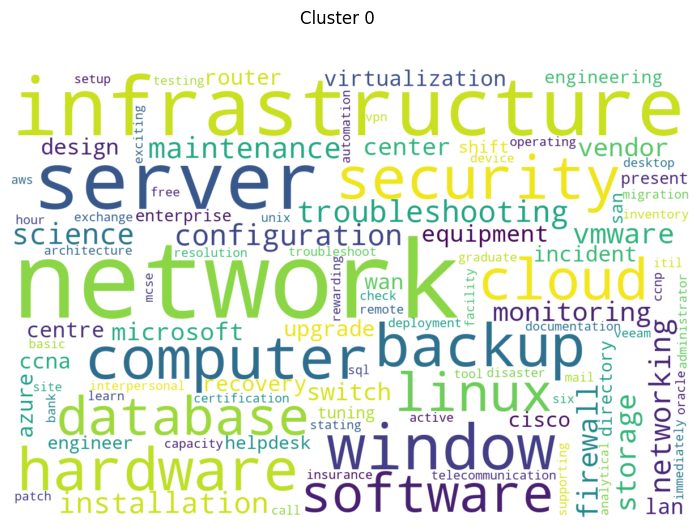

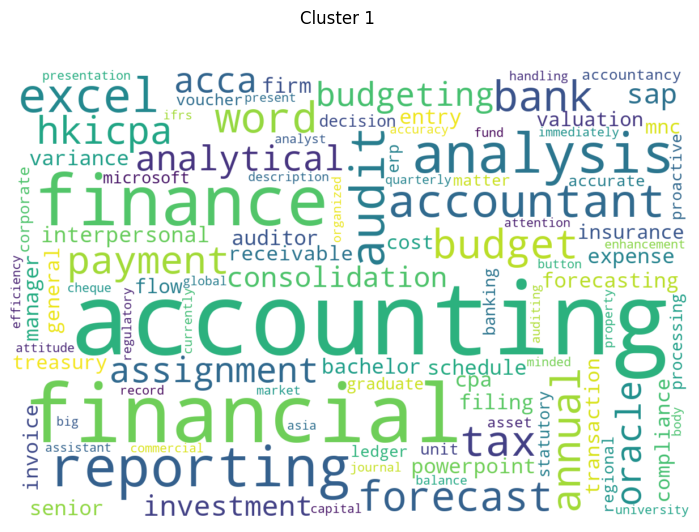

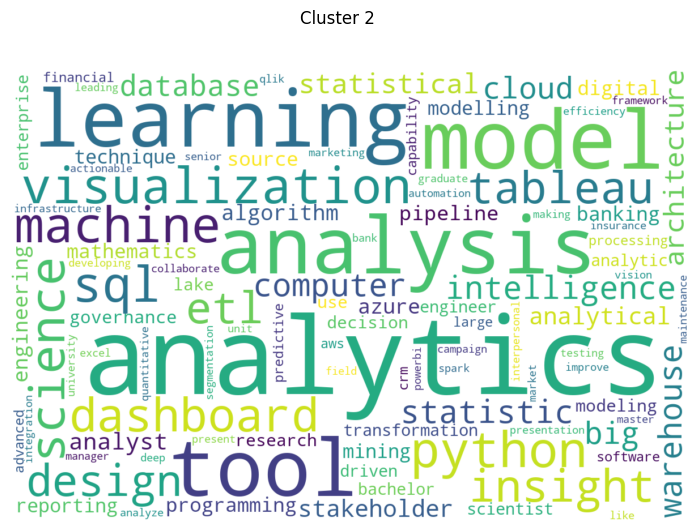

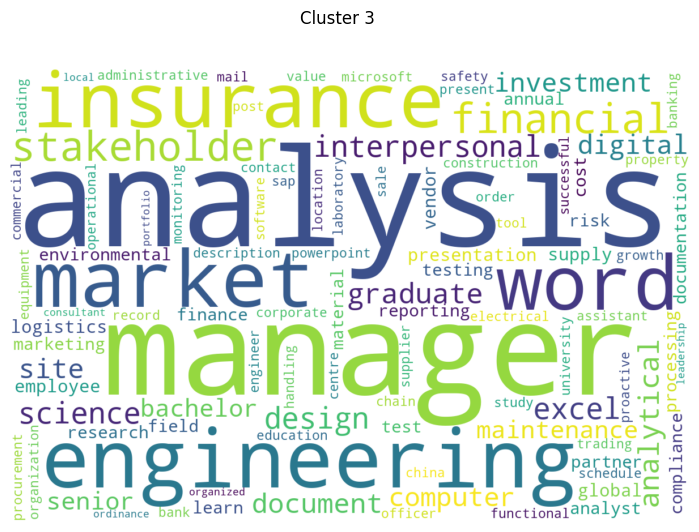

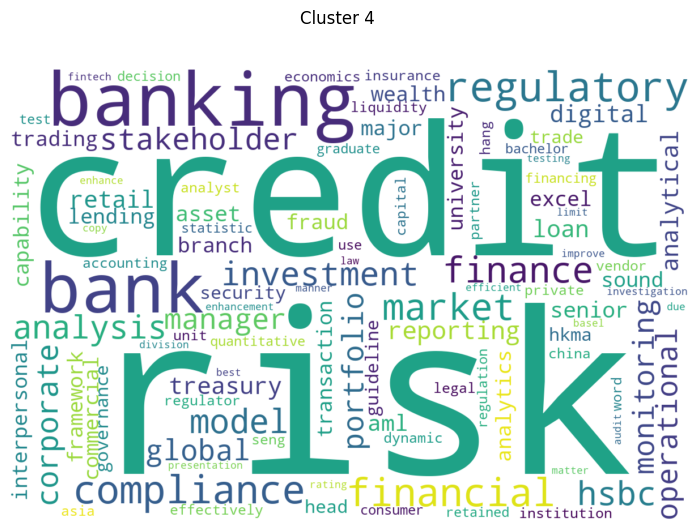

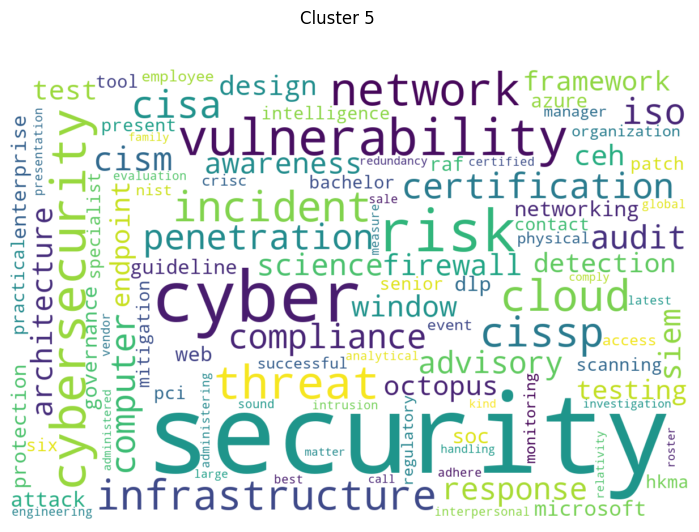

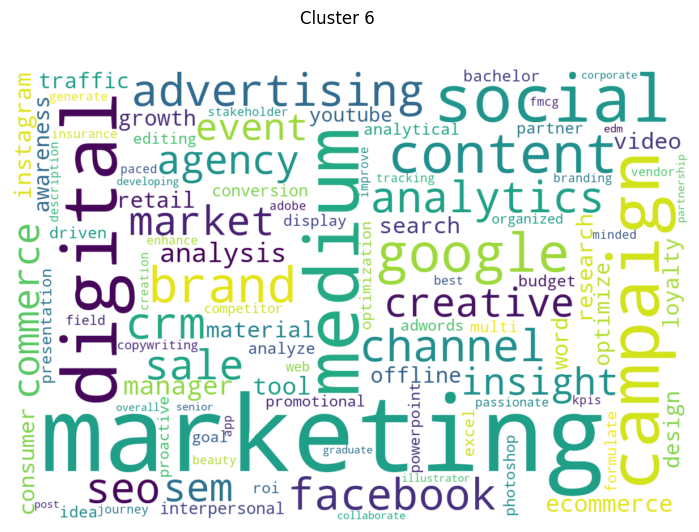

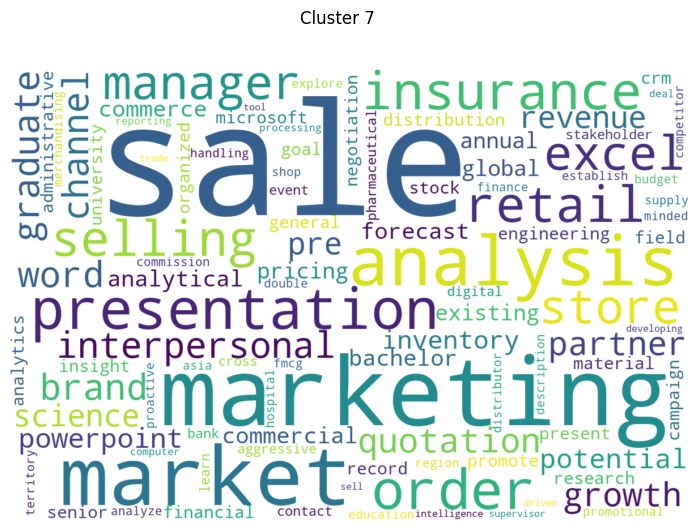

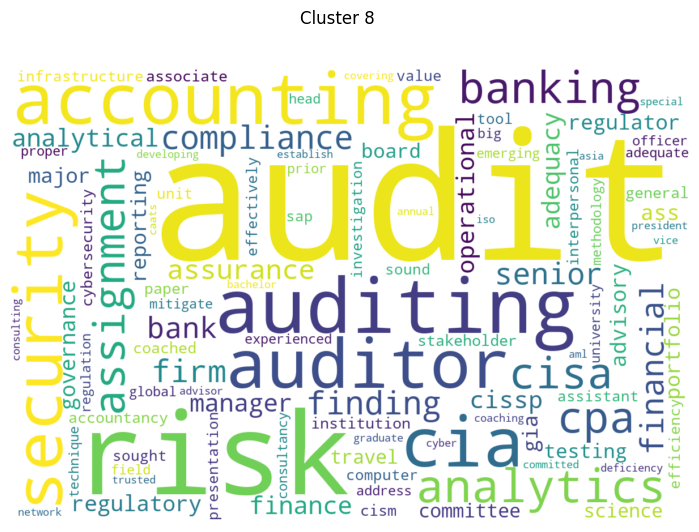

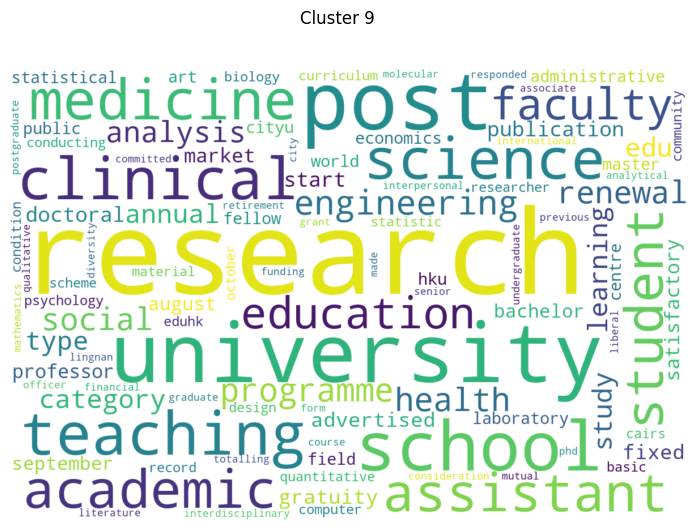

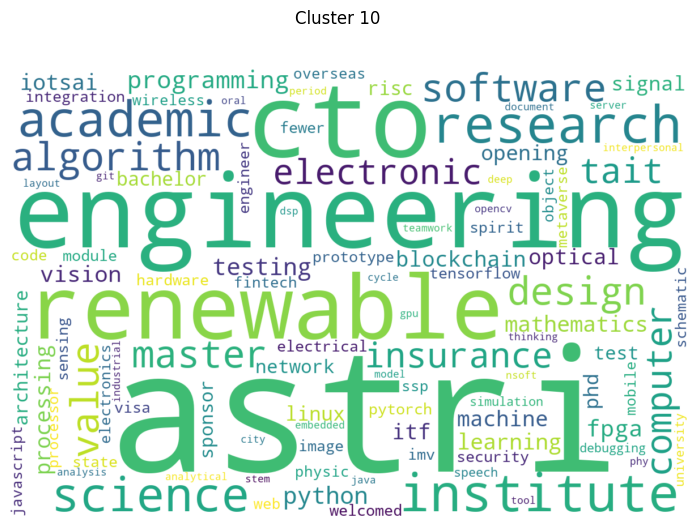

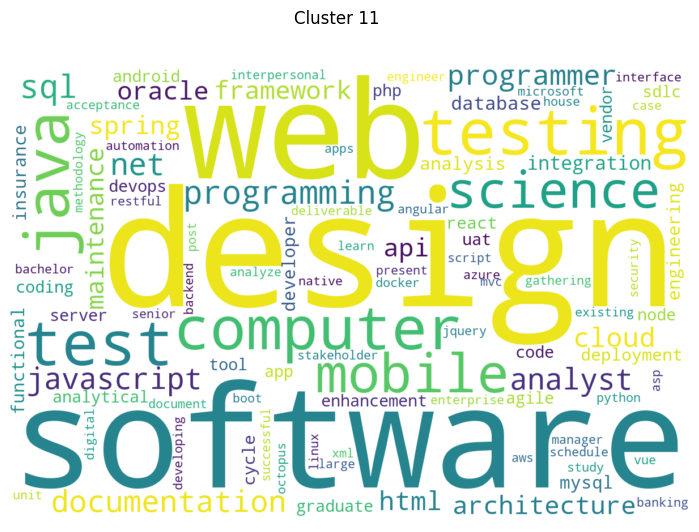

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [13]:
import warnings
warnings.filterwarnings('ignore')

generate_wordclouds(X_svd, X_tfidf, 12, word_positions)

For n_clusters = 5 The average silhouette_score is : 0.06177683210666791


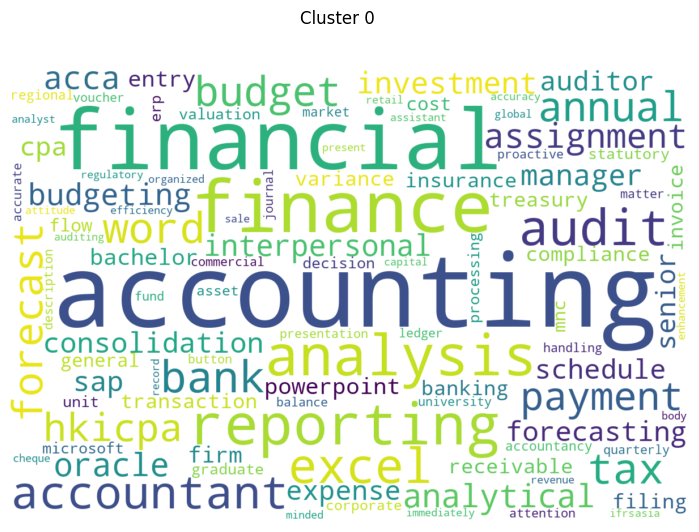

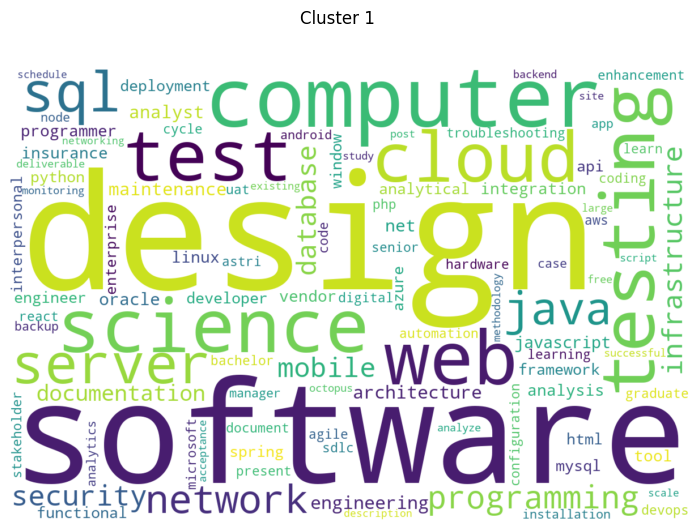

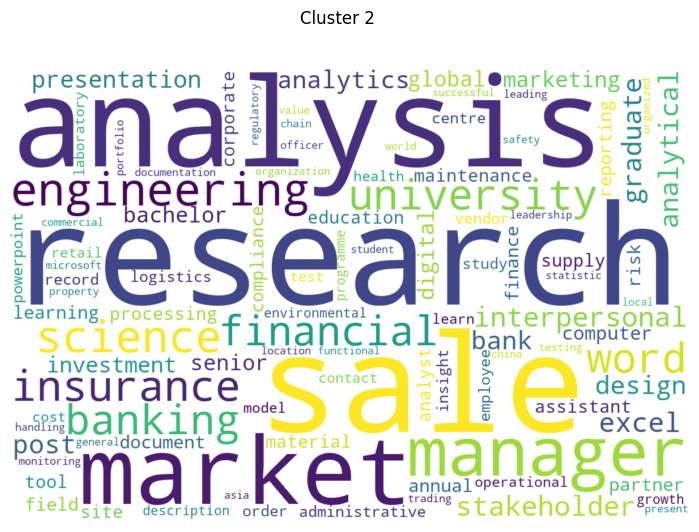

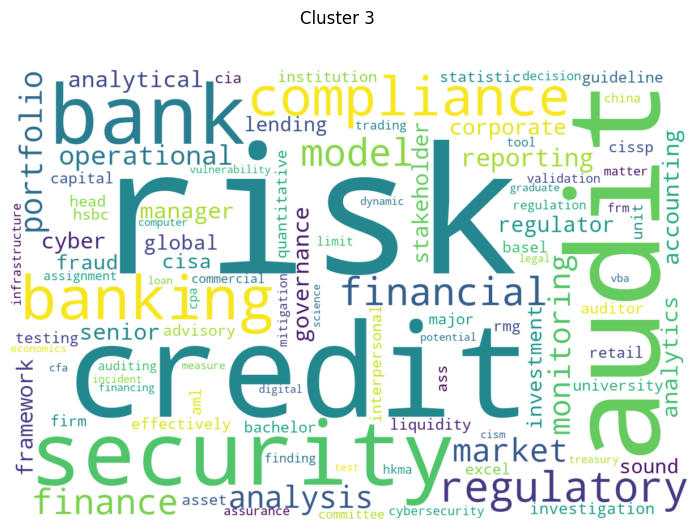

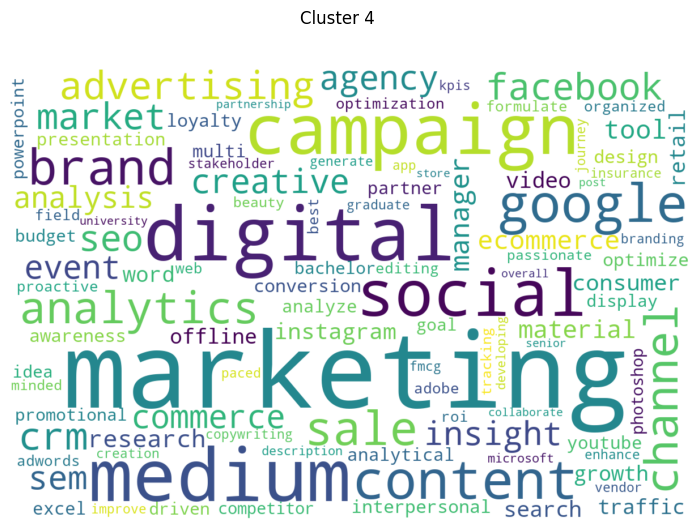

In [17]:
index = generate_wordclouds(X_svd, X_tfidf, 5, word_positions)

In [24]:
df['cluster'] = index
df

job_id                                          job_title  \
0      100003009505754  Distributed Data Analysis Framework Technical ...   
1      100003009506099         System Manager - (System & Infrastructure)   
2      100003009505884  Engineer Project Associate - Small Appliances ...   
3      100003009505952          Facility Engineer (  Facility Management)   
4      110000000155879                       Research Assistant Professor   
...                ...                                                ...   
35642  100003009502482                        Senior IT Portfolio Manager   
35643  100003009504117    People Insights Business Partner - (2200016745)   
35644  100003009504618                                 IT Support Manager   
35645  100003009505110                      Business Analyst (5-day work)   
35646  100003009505124                      Solution Analyst (職位編號：SA-HO)   

                                            company_name  \
0                       Huawei Tech. Investment Co., Ltd   
1                                    Links International   
2                               UL International Limited   
3                           Leadership Solutions Limited   
4                            The University of Hong Kong   
...                                                  ...   
35642                                        Robert Half   
35643            Standard Chartered Bank (Hong Kong) Ltd   
35644             Vantage Data Centers Hong Kong Limited   
35645                      FreightAmigo Services Limited   
35646  Evangelical Lutheran Church Social Service - H...   

                                         job_description            location  \
0      Huawei Hong Kong Research Center Huawei Hong K...         Shatin Area   
1      Our client is a leading IT services company wi...                 NaN   
2      Under general supervision, independently manag...           Kwai Hing   
3      Our client, is a leading IT Infrastructure Pro...                 NaN   
4        Work type:  Full-time   Department:  Departm...          Pok Fu Lam   
...                                                  ...                 ...   
35642  About our client: One of the largest employers...                 NaN   
35643  Role Responsibilities At the start of 2022 the...                 NaN   
35644  About Vantage Data Centers Vantage Data Center...     Kwai Tsing Area   
35645  Job  Highlights FinTech + FreightTech solution...  Yau Tsim Mong Area   
35646  Responsibilities: Review and manage IT system,...            Mong Kok   

      official_post_date  min_official_salary  max_official_salary  \
0             2022-07-12                  NaN                  NaN   
1             2022-07-12                  NaN                  NaN   
2             2022-07-12                  NaN                  NaN   
3             2022-07-12                  NaN                  NaN   
4             2022-07-27                  NaN                  NaN   
...                  ...                  ...                  ...   
35642         2022-07-11                  NaN                  NaN   
35643         2022-07-11                  NaN                  NaN   
35644         2022-07-11                  NaN                  NaN   
35645         2022-07-12                  NaN                  NaN   
35646         2022-07-12                  NaN                  NaN   

      career_level qualification              job_type  \
0           Senior  Postgraduate             Full Time   
1           Middle        Degree  Full Time, Permanent   
2      Entry Level        Degree  Full Time, Permanent   
3           Middle        Degree  Full Time, Permanent   
4              NaN        Degree             Full Time   
...            ...           ...                   ...   
35642       Senior        Degree  Full Time, Permanent   
35643       Middle           NaN  Full Time, Permanent   
35644          NaN           NaN  Full Time, P

In [29]:
df.groupby(['cluster', 'career_level']).mean()

job_id  min_official_salary  max_official_salary  \
cluster career_level                                                           
0       Entry Level   1.000030e+14         21031.250000         27875.000000   
        Middle        1.002071e+14         32900.000000         44633.333333   
        Senior        1.000030e+14         52538.461538         71461.538462   
        Top           1.000030e+14         20000.000000         30000.000000   
1       Entry Level   1.000030e+14         23308.510638         37117.021277   
        Middle        1.000030e+14         35008.695652         54724.637681   
        Senior        1.000030e+14         52960.526316         79735.099338   
        Top           1.000030e+14         86250.000000        137142.857143   
2       Entry Level   1.000030e+14         19822.299652         29766.550523   
        Middle        1.000716e+14         35495.475113         52250.000000   
        Senior        1.000030e+14         53037.974684         76502.145923   
        Top           1.000030e+14         97857.142857        129166.666667   
3       Entry Level   1.000030e+14         20000.000000         25000.000000   
        Middle        1.000030e+14         43571.428571         64107.142857   
        Senior        1.000030e+14         63048.780488         86875.000000   
        Top           1.000030e+14        120000.000000                  NaN   
4       Entry Level   1.000030e+14         17296.296296         26296.296296   
        Middle        1.000030e+14         28192.982456         42543.859649   
        Senior        1.000030e+14         51285.714286         72666.666667   
        Top           1.000030e+14         25000.000000         41666.666667   

                        min_salary     max_salary    mid_salary  
cluster career_level                                             
0       Entry Level   13407.523511   27413.793103  20410.658307  
        Middle        20983.673469   46270.408163  33627.040816  
        Senior        38615.079365   74642.857143  56628.968254  
        Top           65526.315789  113684.210526  89605.263158  
1       Entry Level   14206.512778   34437.345425  24321.929101  
        Middle        21253.710046   53006.563927  37130.136986  
        Senior        33130.246020   75130.246020  54130.246020  
        Top           57333.333333  113333.333333  85333.333333  
2       Entry Level   13226.784477   28432.085932  20829.435204  
        Middle        21964.843080   51348.825244  36656.834162  
        Senior        38377.498572   82872.644203  60625.071388  
        Top           48301.075269   99462.365591  73881.720430  
3       Entry Level   15502.369668   33507.109005  24504.739336  
        Middle        27189.014540   68925.686591  48057.350565  
        Senior        41700.757576   90378.787879  66039.772727  
        Top           56153.846154  112307.692308  84230.769231  
4       Entry Level   12675.872093   27034.883721  19855.377907  
        Middle        17901.826484   40291.095890  29096.461187  
        Senior        32884.476534   70342.960289  51613.718412  
        Top           33333.333333   84166.666667  58750.000000

In [32]:
df.groupby(['cluster', 'career_level'])['location'].agg(pd.Series.mode)

cluster  career_level
0        Entry Level                         Central
         Middle                              Central
         Senior               Central & Western Area
         Top             [Kwun Tong, Others - China]
1        Entry Level                     Kowloon Bay
         Middle                          Kowloon Bay
         Senior                          Kowloon Bay
         Top                  Central & Western Area
2        Entry Level                     Shatin Area
         Middle                          Shatin Area
         Senior                          Shatin Area
         Top                             Shatin Area
3        Entry Level                         Central
         Middle                           Quarry Bay
         Senior                              Central
         Top                              Quarry Bay
4        Entry Level                       Kwun Tong
         Middle                          Kowloon Bay
         Senior         